In [4]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib import axes
from skimage.feature import graycomatrix, graycoprops
from PIL import Image

# Pipeline
GS —> GLCM (mean) \
&ensp; Number of color levels: size of (square) matrix N \
&ensp; Enlist GLCMs of all directions (this can help when tackling rotation invariance)

GLCM —> Normed GLCM \
Normalize GLCM.
ALL first order statistics needed for computing texture features
* mu_x
* mu_y
* sigma_x
* sigma_y
* ...

normed GLCM —> All features \
Compute and Enlist features (Contrast, Energy, Homogeneity, Correlation, Autocorrelation, Cluster prominence, Cluster shade, Difference entropy, Difference variance, Dissimilarity, Entropy, Information measure of correlation 1, Information measure of correlation 2, Inverse difference, Sum average, Sum entropy, Sum of squares, Sum variance) from (Löfstedt et al. 2019).

**Following structure of step 4 in the paper with a Psi component and a Phi component for the function of each feature.**

Refference: Tommy Löfstedt, Patrik Brynolfsson , Thomas Asklund, Tufve Nyholm, Anders Garpebring. "Gray-level invariant Haralick texture features" (2019)

In [22]:
# PRE: Image to Grayscale 

STEP 1: Grayscale to GLCM


In [5]:

def compute_glcms(gs_image, levels = 2):

    glcm0 = graycomatrix(gs_image, distances=[1], angles=[0], levels=levels, symmetric=False)
    glcm45 = graycomatrix(gs_image, distances=[1], angles=[np.pi/4], levels=levels, symmetric=False)
    glcm90 = graycomatrix(gs_image, distances=[1], angles=[np.pi/2], levels=levels, symmetric=False)
    glcm135 = graycomatrix(gs_image, distances=[1], angles=[3 * np.pi/4], levels=levels, symmetric=False)
    mean_glcm = (glcm0 + glcm45 + glcm90 + glcm135)/4

    glcms = {'mean': mean_glcm, '0': glcm0, '45': glcm45, '90': glcm90, '135': glcm135}

    return glcms

STEP 2: Normalize GLCM and Compute First-Order Statistics


In [6]:
def pre_feature_statistics(mean_glcm):

    normed_glcm = mean_glcm / np.sum(mean_glcm)
    N = normed_glcm.shape[0]
    i_indices = np.arange(N) + 1
    j_indices = np.arange(N) + 1
    
    # Marginal probabilities
    p_x = np.sum(normed_glcm, axis=1)  # Sum over j
    p_x = p_x.squeeze()
    p_y = np.sum(normed_glcm, axis=0)  # Sum over i
    p_y = p_y.squeeze()
    
    # Mean values
    indices = np.arange(N) + 1
    mu_x = np.dot(indices, p_x)
    mu_y = np.dot(indices, p_y)
    mu = (mu_x + mu_y) / 2
    
    # Standard deviations
    sigma_x = np.sqrt(np.sum(((i_indices - mu_x) ** 2) * p_x))
    sigma_y = np.sqrt(np.sum(((j_indices - mu_y) ** 2) * p_y))
    
    # HX and HY
    p_x_nonzero = p_x[p_x > 0]
    HX = -np.sum(p_x_nonzero * np.log2(p_x_nonzero))
    
    p_y_nonzero = p_y[p_y > 0]
    HY = -np.sum(p_y_nonzero * np.log2(p_y_nonzero))
    
    # p_x+y and p_x-y 
    p_sum = np.zeros(2 * N - 1)
    p_diff = np.zeros(N)
    
    for i in range(N):
        for j in range(N):
            # p_x+y
            p_sum[i + j] += normed_glcm[i, j]
            # p_x-y
            p_diff[abs(i - j)] += normed_glcm[i, j]
    
    stats = {
        'Pij' : normed_glcm,
        'N': N,
        'mu_x': mu_x,
        'mu_y': mu_y,
        'mu': mu,
        'sigma_x': sigma_x,
        'sigma_y': sigma_y,
        'p_x': p_x,
        'p_y': p_y,
        'HX': HX,
        'HY': HY,
        'p_sum': p_sum,
        'p_diff': p_diff
    }
    
    return stats


### New features

Since original functions are available in scikit-image, we will use their functions as it is more computationally efficient.

STEP 3: Compute Haralick Texture Features \
Structure: Each feature has Psi and Phi components


In [14]:

def compute_autocorrelation(stats):
    normed_glcm = stats['Pij']
    N = normed_glcm.shape[0]

    autocorrelation = 0.0

    for i in range(N):
        for j in range(N):
            i_1 = i + 1
            j_1 = j + 1

            # φ(i,j,g(P)) = i·j
            phi = i_1 * j_1

            # ψ(p(i,j)) = p(i,j)
            psi = normed_glcm[i,j]

            autocorrelation += phi * psi

    return autocorrelation


def compute_cluster_prominence(stats):
    normed_glcm = stats['Pij']
    N = normed_glcm.shape[0]
    p_x = stats['p_x']

    # mu = sum(i * px_i)           ---***---
    # OR mu = mu_x + mu_y          ---***---
    mu =  np.dot(np.arange(1,N+1), p_x)

    cluster_prominence = 0.0

    for i in range(N):
        for j in range(N):
            i_1 = i + 1
            j_1 = j + 1
            
            # φ(i,j,g(P)) = (i + j - 2*mu)^3 
            phi = (i_1 + j_1 - 2 * mu)**3

            # ψ(p(i,j)) = p(i,j)
            psi = normed_glcm[i,j]
            
            cluster_prominence += phi * psi
            
    return cluster_prominence


def compute_cluster_shade(stats):
    normed_glcm = stats['Pij']
    N = normed_glcm.shape[0]
    p_x = stats['p_x']

    # mu = sum(i * px_i)           ---***---
    # OR mu = mu_x + mu_y          ---***---
    mu =  np.dot(np.arange(1,N+1), p_x)

    cluster_shade = 0.0

    for i in range(N):
        for j in range(N):
            i_1 = i + 1
            j_1 = j + 1
            
            # φ(i,j,g(P)) = (i + j - 2*mu)^4 
            phi = (i_1 + j_1 - 2 * mu)**4

            # ψ(p(i,j)) = p(i,j)
            psi = normed_glcm[i,j]
            
            cluster_shade += phi * psi
    
    return cluster_shade


def compute_dissimilarity(stats):
    normed_glcm = stats['Pij']
    N = normed_glcm.shape[0]
    
    dissimilarity = 0.0
    
    for i in range(N):
        for j in range(N):
            i_1 = i + 1
            j_1 = j + 1
            
            # φ(i,j,g(P)) = |i - j|
            phi = abs(i_1 - j_1)
            
            # ψ(p(i,j)) = p(i,j)
            psi = normed_glcm[i, j] 
            
            dissimilarity += phi * psi
    
    return dissimilarity


def compute_entropy(stats):
    normed_glcm = stats['Pij']
    N = normed_glcm.shape[0]
    
    entropy_val = 0.0
    
    for i in range(N):
        for j in range(N):
            p = normed_glcm[i, j]
            if p > 0:
                # φ(i,j,g(P)) = 1
                phi = 1
                
                # ψ(p(i,j)) = -p(i,j) * log(p(i,j))
                psi = -p * np.log(p)
                
                entropy_val += phi * psi
    
    return entropy_val

def compute_difference_entropy(stats):
    normed_glcm = stats['Pij']
    N = normed_glcm.shape[0]
    
    # p_x-y(k)
    p_diff = np.zeros(N)
    
    for i in range(N):
        for j in range(N):
            k = abs((i + 1) - (j + 1))
            if k < N:
                p_diff[k] += normed_glcm[i, j]
    

    diff_entropy = 0.0
    for k in range(N):
        if p_diff[k] > 0:
            diff_entropy -= p_diff[k] * np.log(p_diff[k])
    
    return diff_entropy


def compute_difference_variance(stats):
    normed_glcm = stats['Pij']
    N = normed_glcm.shape[0]
    
    # p_x-y(k)
    p_diff = np.zeros(N)
    
    for i in range(N):
        for j in range(N):
            k = abs((i + 1) - (j + 1))
            if k < N:
                p_diff[k] += normed_glcm[i, j]
    
    # mean
    k_values = np.arange(N)
    mu_diff = np.sum(k_values * p_diff)
    
    # variance
    diff_variance = 0.0
    for k in range(N):
        diff_variance += ((k - mu_diff) ** 2) * p_diff[k]
    
    return diff_variance


def compute_inverse_difference(stats):
    normed_glcm = stats['Pij']
    N = normed_glcm.shape[0]
    
    inv_diff = 0.0
    
    for i in range(N):
        for j in range(N):
            i_1based = i + 1
            j_1based = j + 1
            
            # φ(i,j,g(P)) = 1
            phi = 1
            
            # ψ(p(i,j)) = p(i,j) / (1 + |i-j|)
            psi = normed_glcm[i, j] / (1 + abs(i_1based - j_1based))
            
            inv_diff += phi * psi
    
    return inv_diff


def compute_sum_average(stats):
    normed_glcm = stats['Pij']
    N = normed_glcm.shape[0]

    # Compute p_x+y(k) for k = 2 to 2N
    p_sum = np.zeros(2 * N + 1)
    
    for i in range(N):
        for j in range(N):
            k = (i + 1) + (j + 1)
            if k <= 2 * N:
                p_sum[k] += normed_glcm[i, j]
    
    # Compute sum average
    sum_avg = 0.0
    for k in range(2, 2 * N + 1):
        sum_avg += k * p_sum[k]
    
    return sum_avg


def compute_sum_entropy(stats):
    normed_glcm = stats['Pij']
    N = normed_glcm.shape[0]
    
    p_sum = np.zeros(2 * N + 1)
    
    for i in range(N):
        for j in range(N):
            k = (i + 1) + (j + 1)
            if k <= 2 * N:
                p_sum[k] += normed_glcm[i, j]
    
    # Compute sum entropy
    sum_ent = 0.0
    for k in range(2, 2 * N + 1):
        if p_sum[k] > 0:
            sum_ent -= p_sum[k] * np.log(p_sum[k])
    
    return sum_ent


def compute_sum_of_squares(stats):
    normed_glcm = stats['Pij']
    N = normed_glcm.shape[0]
    mu_x = stats['mu_x']
    
    sum_squares = 0.0
    
    for i in range(N):
        for j in range(N):
            i_1based = i + 1
            
            # φ(i,j,g(P)) = (i - μ_x)^2
            phi = (i_1based - mu_x) ** 2
            
            # ψ(p(i,j)) = p(i,j)
            psi = normed_glcm[i, j]
            
            sum_squares += phi * psi
    
    return sum_squares


def compute_sum_variance(stats):
    normed_glcm = stats['Pij']
    N = normed_glcm.shape[0]
    
    # Compute p_x+y(k) for k = 2 to 2N
    p_sum = np.zeros(2 * N + 1)
    
    for i in range(N):
        for j in range(N):
            k = (i + 1) + (j + 1)
            if k <= 2 * N:
                p_sum[k] += normed_glcm[i, j]
    
    # Compute sum average
    sum_avg = 0.0
    for k in range(2, 2 * N + 1):
        sum_avg += k * p_sum[k]
    
    # Compute sum variance
    sum_var = 0.0
    for k in range(2, 2 * N + 1):
        sum_var += ((k - sum_avg) ** 2) * p_sum[k]
    
    return sum_var



In [15]:

def compute_information_measure_correlation_1(stats):
    normed_glcm = stats['Pij']
    N = normed_glcm.shape[0]
    p_x = stats['p_x']
    p_y = stats['p_y']
    
    # HXY: Entropy of GLCM
    HXY = 0.0
    for i in range(N):
        for j in range(N):
            if normed_glcm[i, j] > 0:
                HXY -= normed_glcm[i, j] * np.log(normed_glcm[i, j])
    
    # HX: Entropy of p_x
    HX = 0.0
    for i in range(N):
        if p_x[i] > 0:
            HX -= p_x[i] * np.log(p_x[i])
    
    # HY: Entropy of p_y
    HY = 0.0
    for j in range(N):
        if p_y[j] > 0:
            HY -= p_y[j] * np.log(p_y[j])
    
    # HXY1: sum over p(i,j) * log(p_x(i) * p_y(j))
    HXY1 = 0.0
    for i in range(N):
        for j in range(N):
            if normed_glcm[i, j] > 0 and p_x[i] > 0 and p_y[j] > 0:
                HXY1 -= normed_glcm[i, j] * np.log(p_x[i] * p_y[j])
    
    # IMC1
    max_HX_HY = max(HX, HY)
    if max_HX_HY > 0:
        imc1 = (HXY - HXY1) / max_HX_HY
    else:
        imc1 = 0.0
    
    return imc1


def compute_information_measure_correlation_2(stats):
    normed_glcm = stats['Pij']
    N = normed_glcm.shape[0]
    p_x = stats['p_x']
    p_y = stats['p_y']
    
    # HXY: Entropy of GLCM
    HXY = 0.0
    for i in range(N):
        for j in range(N):
            if normed_glcm[i, j] > 0:
                HXY -= normed_glcm[i, j] * np.log(normed_glcm[i, j])
    
    # HXY2: sum over p_x(i) * p_y(j) * log(p_x(i) * p_y(j))
    HXY2 = 0.0
    for i in range(N):
        for j in range(N):
            if p_x[i] > 0 and p_y[j] > 0:
                HXY2 -= p_x[i] * p_y[j] * np.log(p_x[i] * p_y[j])
    
    # IMC2
    term = 1 - np.exp(-2 * (HXY2 - HXY))
    imc2 = np.sqrt(max(0, term))
    
    return imc2

## faster functions

In [43]:
def compute_autocorrelation_fast(stats):
    normed_glcm = stats['Pij']
    N = normed_glcm.shape[0]
    I = np.arange(1, N + 1)
    J = np.arange(1, N + 1)

    autocorrelation = I.T @ np.squeeze(normed_glcm) @ J

    return autocorrelation

Uses numpy vectorized operations instead of python nested loops.

In [130]:

def _get_indices(N):
    # Create the matrices of (i+1) and (j+1) indices for vectorization
    indices = np.arange(1, N + 1)
    I = np.repeat(indices.reshape(-1, 1), N, axis=1) # Matrix of row indices (i+1)
    J = np.repeat(indices.reshape(1, -1), N, axis=0) # Matrix of column indices (j+1)
    return I, J


def compute_cluster_prominence_fast(stats):
    normed_glcm = stats['Pij']
    N = normed_glcm.shape[0]
    p_x = stats['p_x']
    I, J = _get_indices(N)

    # mu is calculated using dot product on the flattened index array and marginal probability
    mu = np.dot(np.arange(1, N + 1), p_x)

    # Cluster Prominence = sum( (i + j - 2*mu)^3 * Pij )
    # (I + J - 2 * mu) computes the inner term for all elements simultaneously
    phi_matrix = (I + J - 2 * mu)**3
    cluster_prominence = np.sum(phi_matrix * normed_glcm)
    return cluster_prominence


def compute_cluster_shade_fast(stats):
    normed_glcm = stats['Pij']
    N = normed_glcm.shape[0]
    p_x = stats['p_x']
    I, J = _get_indices(N)

    mu = np.dot(np.arange(1, N + 1), p_x)

    # Cluster Shade = sum( (i + j - 2*mu)^4 * Pij )
    phi_matrix = (I + J - 2 * mu)**4
    cluster_shade = np.sum(phi_matrix * normed_glcm)
    return cluster_shade


def compute_dissimilarity_fast(stats):
    normed_glcm = stats['Pij']
    N = normed_glcm.shape[0]
    I, J = _get_indices(N)

    # Dissimilarity = sum( |i - j| * Pij )
    # abs(I - J) computes the |i - j| term for all elements
    dissimilarity = np.sum(np.abs(I - J) * normed_glcm)
    return dissimilarity


def compute_entropy_fast(stats):
    normed_glcm = stats['Pij']

    # Entropy = sum( -Pij * log(Pij) ) for Pij > 0
    # Use boolean indexing to only consider non-zero elements
    non_zero_P = normed_glcm[normed_glcm > 0]

    # np.log is a vectorized operation
    # The sum is over the non-zero elements only
    entropy_val = -np.sum(non_zero_P * np.log(non_zero_P))
    return entropy_val

# Tests

In [15]:
from numba import njit
import numpy as np

@njit(cache=True)
def autocorr_matmul(P):
    N = P.shape[0]
    I = np.arange(1, N + 1, dtype=np.float64)
    J = np.arange(1, N + 1, dtype=np.float64)
    
    return np.sum(I * J * P)

In [16]:
def compute_features_plot(image_in, tile_s=8, tile_o=4, N=256):
    image_in = image_in.convert('L')
    image_in_array = np.array(image_in)
    row_size = image_in_array.shape[0]
    col_size = image_in_array.shape[1]

    tiles = []
    glcms = []
    
    # Initialize lists for all features
    # contrast_value = []
    # correlation_value = []
    # homogeneity_value = []
    # energy_value = []
    autocorrelation_value = []
    # cluster_prominence_value = []
    # cluster_shade_value = []
    # dissimilarity_value = []
    # entropy_value = []

    for r in range(0, row_size - tile_s + 1, tile_o):
        for c in range(0, col_size - tile_s + 1, tile_o):
            tile = image_in_array[r:r+tile_s, c:c+tile_s]
            tiles.append(tile)
            distances = [1]

            glcm0 = graycomatrix(tile, distances=distances, angles=[0], levels=N, symmetric=False)
            glcm1 = graycomatrix(tile, distances=distances, angles=[np.pi/4], levels=N, symmetric=False)
            glcm2 = graycomatrix(tile, distances=distances, angles=[np.pi/2], levels=N, symmetric=False)
            glcm3 = graycomatrix(tile, distances=distances, angles=[3 * np.pi/4], levels=N, symmetric=False)

            glcm = (glcm0 + glcm1 + glcm2 + glcm3) / 4
            glcms.append(glcm)
            
            # Create stats dictionary for custom features
            stats = pre_feature_statistics(glcm)

            # Standard features
            # contrast = float(graycoprops(glcm, 'contrast'))
            # correlation = float(graycoprops(glcm, 'correlation'))
            # homogeneity = float(graycoprops(glcm, 'homogeneity'))
            # energy = float(graycoprops(glcm, 'energy'))
            
            # Custom features
            P = np.squeeze(stats['Pij'])
            autocorrelation = autocorr_matmul(P)
            # cluster_prominence = compute_cluster_prominence(stats)
            # cluster_shade = compute_cluster_shade(stats)
            # dissimilarity = compute_dissimilarity(stats)
            # entropy = compute_entropy(stats)

            # contrast_value.append(contrast)
            # correlation_value.append(correlation)
            # homogeneity_value.append(homogeneity)
            # energy_value.append(energy)
            autocorrelation_value.append(autocorrelation)
            # cluster_prominence_value.append(cluster_prominence)
            # cluster_shade_value.append(cluster_shade)
            # dissimilarity_value.append(dissimilarity)
            # entropy_value.append(entropy)

    # Normalize all features using min-max
    def normalize_feature(values):
        val_max = max(values)
        val_min = min(values)
        if val_max - val_min == 0:
            return [0.5] * len(values), val_min, val_max
        return [(val - val_min) / (val_max - val_min) for val in values], val_min, val_max

    # contrast_values, contrast_min, contrast_max = normalize_feature(contrast_value)
    # correlation_values, correlation_min, correlation_max = normalize_feature(correlation_value)
    # homogeneity_values, homogeneity_min, homogeneity_max = normalize_feature(homogeneity_value)
    # energy_values, energy_min, energy_max = normalize_feature(energy_value)
    autocorrelation_values, autocorrelation_min, autocorrelation_max = normalize_feature(autocorrelation_value)
    # cluster_prominence_values, cluster_prominence_min, cluster_prominence_max = normalize_feature(cluster_prominence_value)
    # cluster_shade_values, cluster_shade_min, cluster_shade_max = normalize_feature(cluster_shade_value)
    # dissimilarity_values, dissimilarity_min, dissimilarity_max = normalize_feature(dissimilarity_value)
    # entropy_values, entropy_min, entropy_max = normalize_feature(entropy_value)

    # Reshape features into arrays
    shape = (int(2*(row_size/tile_s) - 1), int(2*(col_size/tile_s) - 1))
    
    # contrast_array = np.reshape(contrast_values, shape)
    # correlation_array = np.reshape(correlation_values, shape)
    # homogeneity_array = np.reshape(homogeneity_values, shape)
    # energy_array = np.reshape(energy_values, shape)
    autocorrelation_array = np.reshape(autocorrelation_values, shape)
    # cluster_prominence_array = np.reshape(cluster_prominence_values, shape)
    # cluster_shade_array = np.reshape(cluster_shade_values, shape)
    # dissimilarity_array = np.reshape(dissimilarity_values, shape)
    # entropy_array = np.reshape(entropy_values, shape)

    # Create figure with 5 rows and 2 columns (10 subplots total)
    fig, ax = plt.subplots(5, 2, figsize=(10, 14))

    # Original Image
    original = ax[0, 0].imshow(image_in_array, cmap='gray')
    ax[0, 0].axis('off')
    ax[0, 0].set_title("Original Image")
    fig.colorbar(original, ax=ax[0, 0])

    # Contrast
    # contrast_img = ax[0, 1].imshow(contrast_array, cmap='Reds')
    # ax[0, 1].axis('off')
    # ax[0, 1].set_title("Contrast")
    # cbar = fig.colorbar(contrast_img, ax=ax[0, 1])
    # cbar.set_ticks(ticks=[0, 1], labels=[round(contrast_min, 4), round(contrast_max, 4)])

    # Homogeneity
    # homogeneity_img = ax[1, 0].imshow(homogeneity_array, cmap='Reds')
    # ax[1, 0].axis('off')
    # ax[1, 0].set_title("Homogeneity")
    # cbar = fig.colorbar(homogeneity_img, ax=ax[1, 0])
    # cbar.set_ticks(ticks=[0, 1], labels=[round(homogeneity_min, 4), round(homogeneity_max, 4)])

    # Correlation
    # correlation_img = ax[1, 1].imshow(correlation_array, cmap='Reds')
    # ax[1, 1].axis('off')
    # ax[1, 1].set_title("Correlation")
    # cbar = fig.colorbar(correlation_img, ax=ax[1, 1])
    # cbar.set_ticks(ticks=[0, 1], labels=[round(correlation_min, 4), round(correlation_max, 4)])

    # Energy
    # energy_img = ax[2, 0].imshow(energy_array, cmap='Reds')
    # ax[2, 0].axis('off')
    # ax[2, 0].set_title("Energy")
    # cbar = fig.colorbar(energy_img, ax=ax[2, 0])
    # cbar.set_ticks(ticks=[0, 1], labels=[round(energy_min, 4), round(energy_max, 4)])

    # Autocorrelation
    autocorrelation_img = ax[2, 1].imshow(autocorrelation_array, cmap='Reds')
    ax[2, 1].axis('off')
    ax[2, 1].set_title("Autocorrelation")
    cbar = fig.colorbar(autocorrelation_img, ax=ax[2, 1])
    cbar.set_ticks(ticks=[0, 1], labels=[round(autocorrelation_min, 4), round(autocorrelation_max, 4)])

    # Cluster Prominence
    # cluster_prominence_img = ax[3, 0].imshow(cluster_prominence_array, cmap='Reds')
    # ax[3, 0].axis('off')
    # ax[3, 0].set_title("Cluster Prominence")
    # cbar = fig.colorbar(cluster_prominence_img, ax=ax[3, 0])
    # cbar.set_ticks(ticks=[0, 1], labels=[f'{cluster_prominence_min:.2e}', f'{cluster_prominence_max:.2e}'])

    # Cluster Shade
    # cluster_shade_img = ax[3, 1].imshow(cluster_shade_array, cmap='Reds')
    # ax[3, 1].axis('off')
    # ax[3, 1].set_title("Cluster Shade")
    # cbar = fig.colorbar(cluster_shade_img, ax=ax[3, 1])
    # cbar.set_ticks(ticks=[0, 1], labels=[f'{cluster_shade_min:.2e}', f'{cluster_shade_max:.2e}'])

    # Dissimilarity
    # dissimilarity_img = ax[4, 0].imshow(dissimilarity_array, cmap='Reds')
    # ax[4, 0].axis('off')
    # ax[4, 0].set_title("Dissimilarity")
    # cbar = fig.colorbar(dissimilarity_img, ax=ax[4, 0])
    # cbar.set_ticks(ticks=[0, 1], labels=[round(dissimilarity_min, 4), round(dissimilarity_max, 4)])

    # Entropy
    # entropy_img = ax[4, 1].imshow(entropy_array, cmap='Reds')
    # ax[4, 1].axis('off')
    # ax[4, 1].set_title("Entropy")
    # cbar = fig.colorbar(entropy_img, ax=ax[4, 1])
    # cbar.set_ticks(ticks=[0, 1], labels=[round(entropy_min, 4), round(entropy_max, 4)])

    plt.tight_layout()
    plt.show()

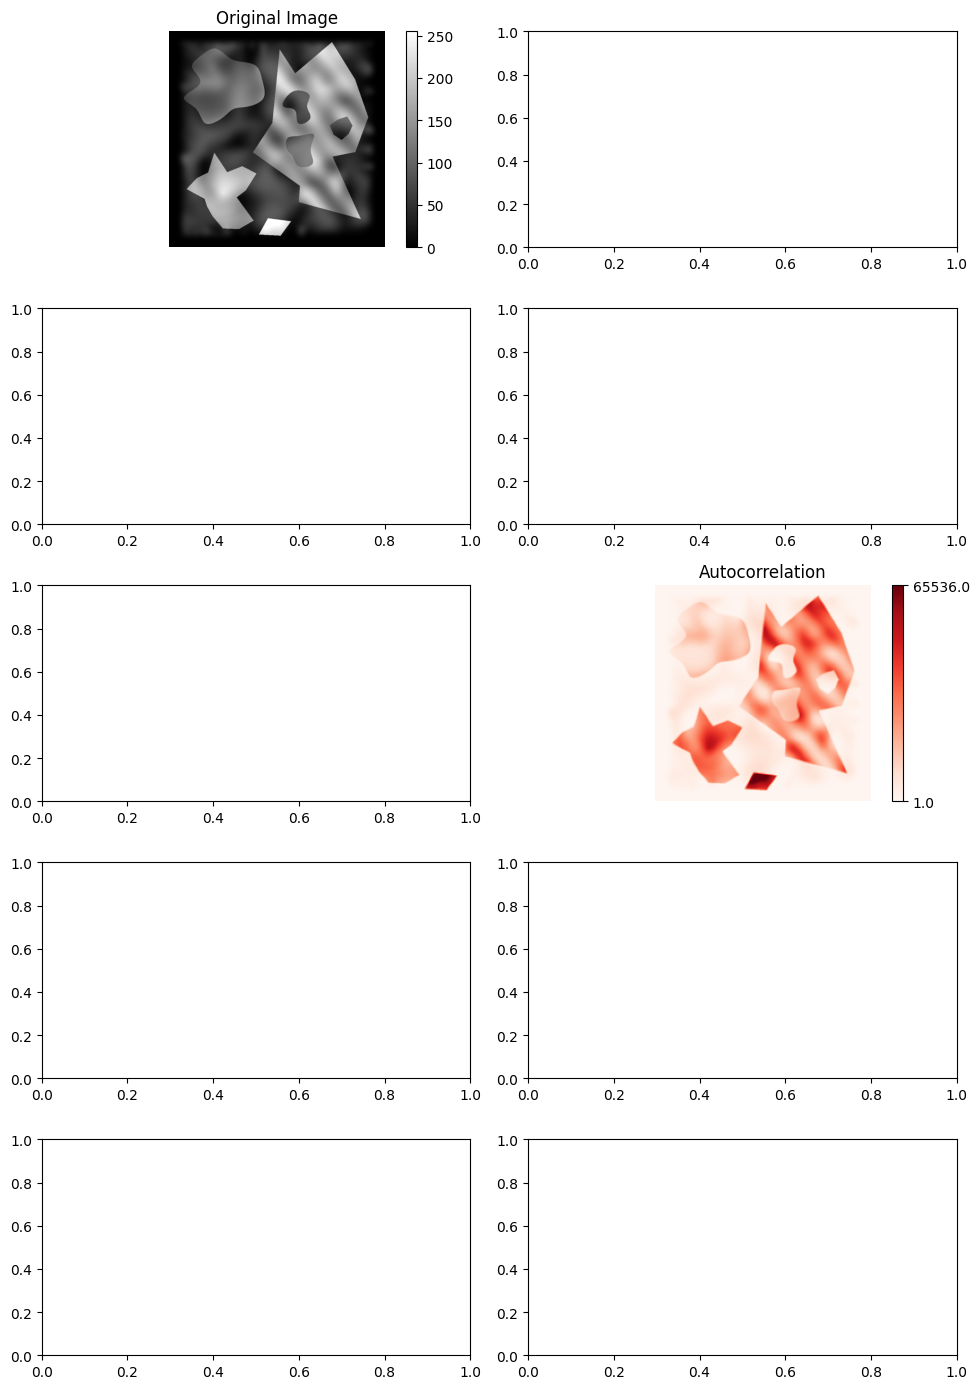

In [17]:
image=Image.open('/Users/mussa/Desktop/PROJECTS/Data_edge/edgeEvalSimple.png')
compute_features_plot(image)